# OONI Data Analysis

In [25]:
# Basic Imports
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

# Plotting Imports
from matplotlib import pyplot as plt
import seaborn as sns

# scipy
from scipy.stats import ttest_ind

# sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Statstools
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Plot configuration
sns.set_style('darkgrid')
sns.set_palette('tab10')
palette = sns.color_palette()

In [3]:
# Data paths
base_dir = '../../Data/'
hr_dir = os.path.join(base_dir, 'HR', 'processed')
hr_years = ['2021', '2022', '2023']
np_dir = os.path.join(base_dir, 'NP', 'processed')
np_years = ['2022']
by_dir = os.path.join(base_dir, 'BY', 'processed')
by_years = ['2022']

## (1) Introduction

(INTRODUCTION)

### (1.1) Dataset

*You must provide background on the dataset or datasets you
worked with, such as who created it, why, how it was collected, for what purpose
it was collected, what attributes are included, what representation decisions
were made and how that affects the data, etc. A good reference for questions
to ask about your data is the paper “Datasheets for Datasets,” by Gebru et al.
(2018) (https://arxiv.org/abs/1803.09010).*

Our dataset was created by the Open Observatory of Network Interference (OONI), a non-profit organization based in Italy focused on fighting internet censorship worldwide. The project was originally founded by The Tor Project, but now most of its funding comes from donations.

The dataset comes from the OONI Probe, a mobile app launched by OONI in 2017. At the time, it collected the largest dataset on internet censorship ever recorded. To this day, it remains the largest publicly available dataset on the topic. The app runs in the background on any phone that has it installed. OONI organizes coordinated tests, where phones in a specific region perform tests at the same time. These phones send internet requests to various sources, and the responses are reported back to a server at OONI’s headquarters. This process provides a broad overview of internet connectivity in regions with OONI app users. Researchers can analyze the data to identify sites and services that are consistently blocked, or use models to detect significant changes in internet access.

When sites are temporarily blocked, often due to political reasons, this is referred to as "temporal blocking." We chose this dataset to analyze after reading a paper (https://www.ndss-symposium.org/ndss-paper/modeling-and-detecting-internet-censorship-events/) that identified instances of temporal blocking in Nepal in 2022. Temporal blocking is a major challenge facing the free world. Smaller, and less indistrialized nations often get away with temporal blocking of political content around elections. Our goal for this project revolves around characterizing temporal censorship events.

The OONI probe performs at least 17 different types of tests. We won't go over all of them here, but we decided to focus on the web connectivity tests due to the large amount of data, and ease of interpretation. These tests first send out a DNS request for the targeted domain, and report if the DNS request returned as expected. If so, they then send out an HTTPS request to the domain, and record the response. This gives a broad view of whether citizens in a specific region are able to access content that OONI deems important or controversial. A control connection is also sent out at the same time called a "test helper". The responses of the test helper, and the tests are compared to create the final data point.

The web connectivity tests are massive. We started by trying to download certain chunks of data, and discovered that the data for the United States for one month was over 140 GB. The entire OONI database is several terabytes of data. We simply did not have the resources to work with that much data. We decided to focus on specific regions during the same timeframe to perform our analysis. Due to the paper that we read, we started with Nepal 2022. We decided to analyze two other countries during the same timeframe, to use as points of comparison: Croatia and Belarus. We were looking for other small countries, and we wanted two countries on opposite sides of the censorship spectrum. Belarus is a well known censored country, and Croatia's constitution bans any form of internet censorship, thus they seemed like a perfect choice. Due to some issues with the dataset that we will discuss later, we ended up pivoting to focus on Croatia, and thus downloaded the Croatia 2021 and 2023 datasets as well to supplement our study.

In [4]:
# Load all datasets
web_data = {
    'hr' : {
        year : pd.read_csv(os.path.join(hr_dir, year, 'webconnectivity.csv')) for year in hr_years
    },
    'np' : {
        year : pd.read_csv(os.path.join(np_dir, year, 'webconnectivity.csv')) for year in np_years
    },
    'by' : {
        year : pd.read_csv(os.path.join(by_dir, year, 'webconnectivity.csv')) for year in by_years
    }
}

# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path

# Loop through all datasets and clean
for country in web_data:
    for year in web_data[country]:
        wd = web_data[country][year]
        wd['date'] = pd.to_datetime(wd['date'])
        wd = wd.set_index('date')
        wd['input'] = wd['input'].map(url_standardize)
        web_data[country][year] = wd

The structure of the data is as follows. There are 18 different fields in the dataset:

- Date - when the test occured
- Probe_asn - what network the test occured in, using the unique Autonomous System number
- Status_code_match - whether the HTTPS status code matches between the test and control
- Resolver_asn - what network the DNS resolver contacted is located in
- X_null_null_flags - unused
- Body_length_match - whether the length of the response body match between the test and control
- DNS_consistency - whether the DNS resolution is consistent between the test and control
- Headers_match - whether the final response headers match between the test and control
- DNS_experiment_failure - describes the specific failures of any DNS request
- HTTP_experiment_failure - describes the specific failures of any HTTP request
- Body_proportion - The ratio of body lengths between the control and test response
- Title_match - whether the final response title matches between the test and control
- Blocking - says whether the domain has been judged to be blocked or not by OONI's algorithm
- Accessible - whether or not the final response was able to reach the requested domain
- X_dns_flags - unused
- Control_failure - describes the specific failures of any control request
- X_blocking_flags - unused
- input - the domain the test wanted to connect to

Example data (Nepal 2022):

In [5]:
# Show some example data
web_data['np']['2022']

,probe_asn,http_experiment_failure,x_dns_flags,status_code_match,resolver_asn,headers_match,blocking,body_length_match,input,control_failure,title_match,accessible,x_null_null_flags,x_blocking_flags,body_proportion,dns_consistency,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,fteproxy.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,sbc.net/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,ecequality.org/,NaN,True,True,NaN,NaN,1.000000,inconsistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,episcopalchurch.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,icrw.org/,NaN,True,True,NaN,NaN,0.999723,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,True,facebook.com/,NaN,NaN,True,NaN,NaN,0.975015,consistent,NaN
2022-12-31,AS23752,NaN,NaN,False,AS23752,True,False,NaN,instagram.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,NaN,youtube.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN


Of these fields, we care about 3 of them for our analysis: `date`, `input`, and `blocking`. Luckily for us, the `blocking` field already does all of the preprocessing we would need to detect blocking events. This field analyzes each of the other fields to tell us whether or not blocking has occurred, and what type of blocking the heuristics believe has occurred. The possible values are as follows:

In [6]:
# Show unique test types
event_types_disp = pd.Series(web_data['hr']['2022']['blocking'].sort_values().unique())
pd.DataFrame(event_types_disp, columns=['Blocking Type'])

,Blocking Type
0,False
1,dns
2,http-diff
3,http-failure
4,tcp_ip
5,NaN


In [7]:
event_types = pd.Series(web_data['hr']['2022']['blocking'].dropna().sort_values().unique())

These specific blocking test responses are:

* `False` - No blocking methods were detected
  * Either the site is accessible, or the site is inaccesible to both the test and control groups.
* `NaN` - The results of the test were inconclusive, and thus should be discarded
  * We ignore these in our visualization, and model creation.
* `dns` - The DNS server does not resolve the site properly
  * This is a common method of censorship. Detected by comparing the test and control DNS responses. Returns if the test gets a DNS error that the control doesn't, or if the test and control resolve to different IP addresses. Both are signs of network errors, or censorship
* `httpdiff` - The HTTP response differs between test and control.
  * Some groups implement censorship using firewalls with distinct blockpages. This is detected by analyzing the body_length_match, headers_match, and title_match. If the body_length does not match, but the body proportion is below a threshold, it does not flag for censorship.
* `httpfail` - The HTTP response returns with a failure error code, while the control does not
  * Many groups do censorship using deep packet inspection to see the content of your sent message. If the content is in some way objectionable to them, they return a 404 error or something similar to censor your request.
* `tcp` - The response returned with the TCP RST flag set to 1
  * This flag is normally used when a machine needs to suddenly halt communication for any reason. Groups implement IP address blocking by viewing the IP address of the destination, and stopping the packet. They then send back a packet with the TCP RST flag set to 1. This kills the TCP session, and displays the message "This site can't be reached" to the user.


So to recap, our dataset is the OONI censorship dataset for Croatia 2021-2023, Belarus for 2022, and Nepal for 2022. We are analyzing the blocking patterns during that time frame as a time series. We believe we can use this data to figure out more about temporal censorship in the world. But what specific questions do we want to answer?

In [8]:
# Filter data into specific blocking methods
blocking_events = {
    country : {
        year : {
            event_type: web_data[country][year][web_data[country][year]['blocking'] == event_type]
            for event_type in event_types
        } for year in web_data[country]
    } for country in web_data
}

In [9]:
# Compute rolling totals, means, and standard deviations
k=7
totals = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
means = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
stds = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quarts = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quants = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
for country in blocking_events:
    for year in blocking_events[country]:
        for event_type in blocking_events[country][year]:
            # Calculate date range
            date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

            # Fill all empty events with zeroes
            d = blocking_events[country][year][event_type]
            tmp = d.groupby(d.index).size()
            totals[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()
            means[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().dropna()
            stds[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).std().dropna()
            quarts[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.25, 0.75]).dropna()
            quants[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.01, 0.1, 0.9, 0.99]).dropna()

In [10]:
# Calculate fractional events
fracs = {country : { year : {} for year in totals[country] } for country in totals}
for country in totals:
    for year in totals[country]:
        # Calculate fractional of all possible events
        d = pd.DataFrame(totals[country][year])
        tsum = d.sum(axis=1)
        fracs[country][year] =  d.div(tsum, axis=0).fillna(0)

Let's take a look at what types of events are occurring throughout time in various countries.

#### (1.1.1) Nepal 2022

The following plot shows the total fraction of events that correspond to any of the four main blocking types of the measurements that were taken on any given day in Nepal during 2022.  There are some gaps where the data is missing values due to not having enough measurements on specific days.  The window size is set to $7$ to capture a rolling total over a week to get a sense of the movement of events over that period of time.

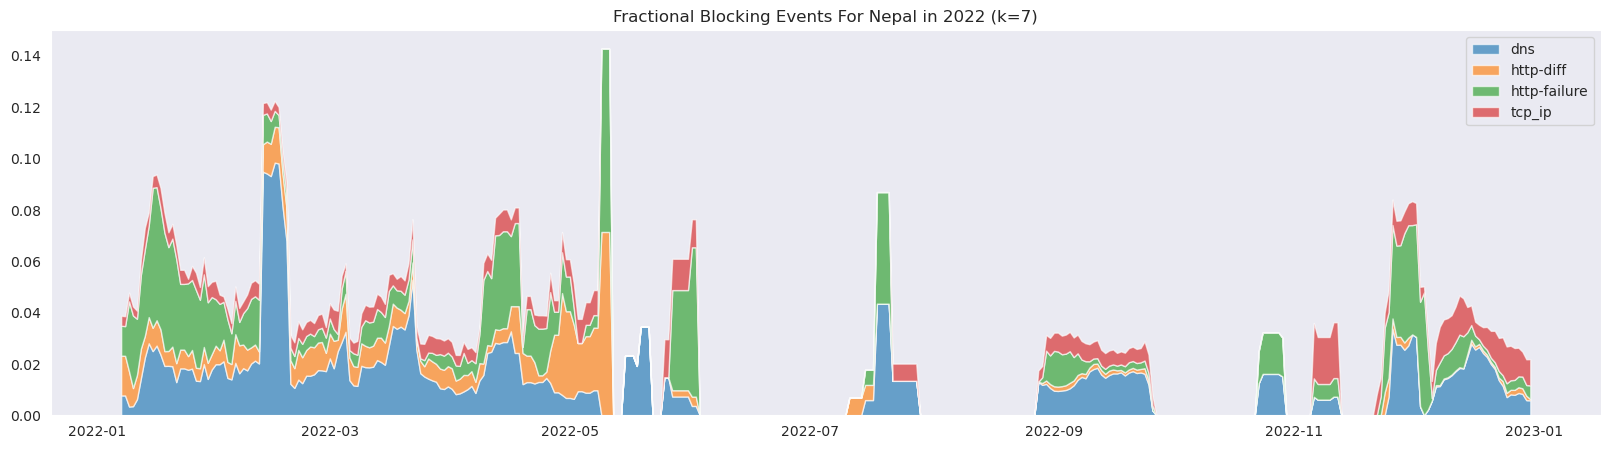

In [11]:
# Select a country and year
country = 'np'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Nepal in {year} (k={k})')
plt.show()

The plot below shows the mean $+/-$ one standard deviation as an area around the mean for each type of blocking event over time.

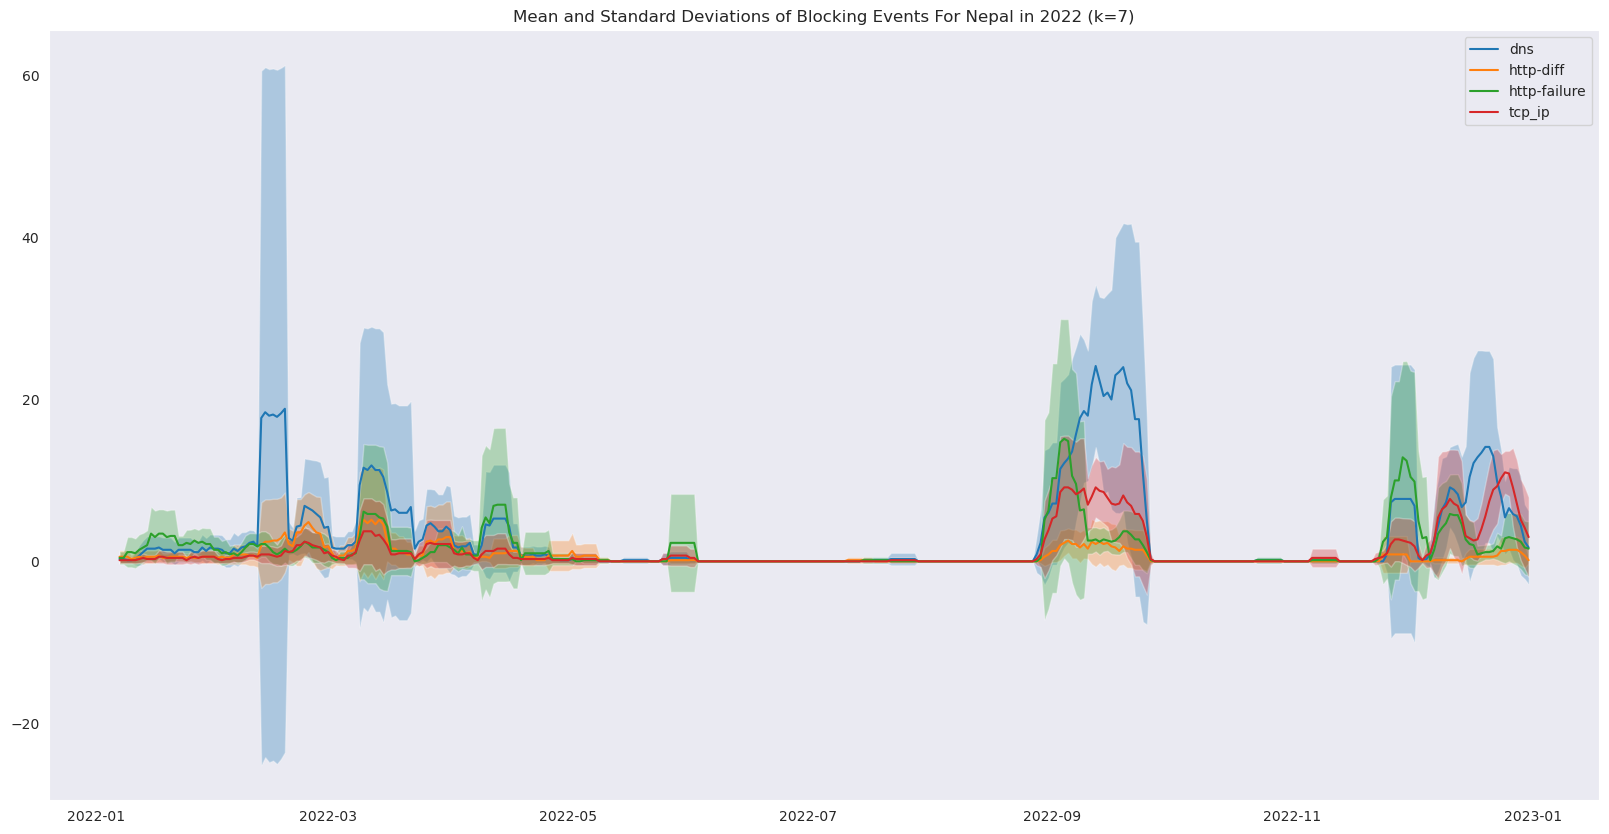

In [12]:
# Get means and standard deviations
m = pd.DataFrame(means[country][year])
m = m.reindex(sorted(m.columns), axis=1)
m = m.drop('False', axis=1)
s = pd.DataFrame(stds[country][year])
s = s.reindex(sorted(s.columns), axis=1)
s = s.drop('False', axis=1)

# Plot mean and standard deviations
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(m, label=m.columns)
for t in m.columns:
    plt.fill_between(m.index, m[t]-s[t], m[t]+s[t], alpha=0.3)
plt.legend()
plt.grid()
plt.title(f'Mean and Standard Deviations of Blocking Events For Nepal in {year} (k={k})')
plt.show()

#### (1.1.2) Belarus 2022

We show the same types of plots for Belarus during 2022, which is considered by OONI to be a relatively highly censored country.  It's clear that the blocking events are more stable and constantly high fractional values.

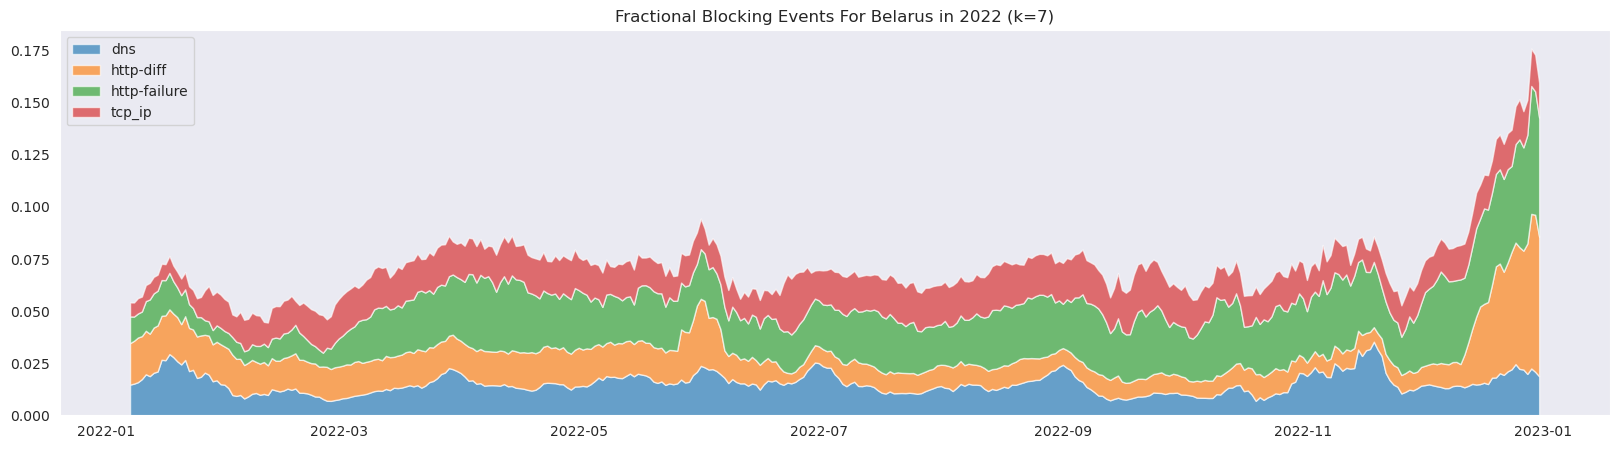

In [13]:
# Select a country and year
country = 'by'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Belarus in {year} (k={k})')
plt.show()

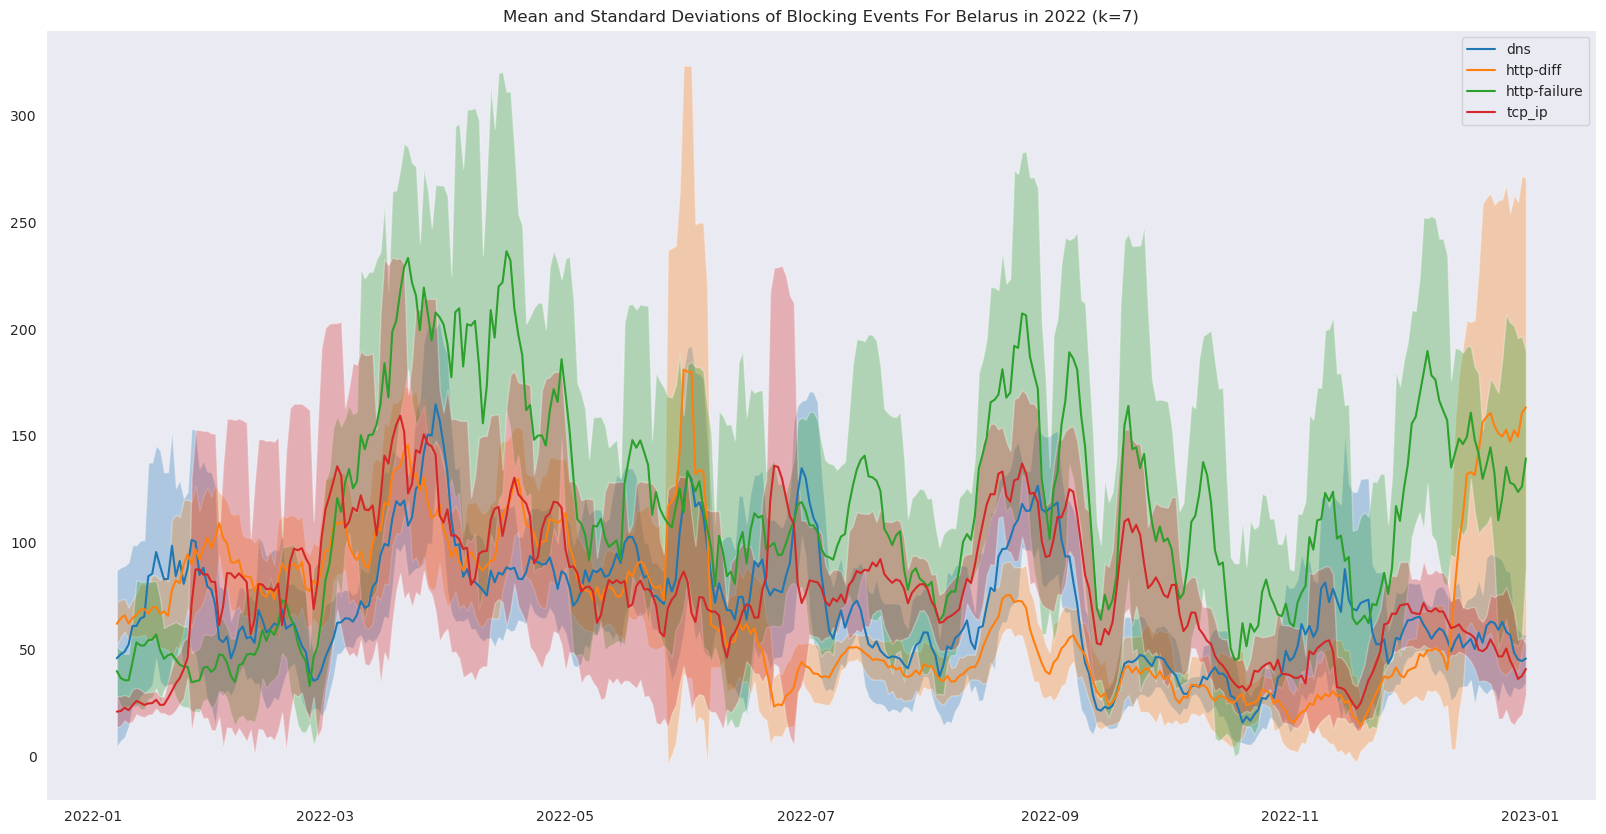

In [14]:
# Get means and standard deviations
m = pd.DataFrame(means[country][year])
m = m.reindex(sorted(m.columns), axis=1)
m = m.drop('False', axis=1)
s = pd.DataFrame(stds[country][year])
s = s.reindex(sorted(s.columns), axis=1)
s = s.drop('False', axis=1)

# Plot mean and standard deviations
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(m, label=m.columns)
for t in m.columns:
    plt.fill_between(m.index, m[t]-s[t], m[t]+s[t], alpha=0.3)
plt.legend()
plt.grid()
plt.title(f'Mean and Standard Deviations of Blocking Events For Belarus in {year} (k={k})')
plt.show()

#### (1.1.3) Croatia 2022

We initially selected Croatia as a contrast to Belarus since it is considered to be a non-censored country, however what we found was quite a bit more interesting than expected upon first inspection.

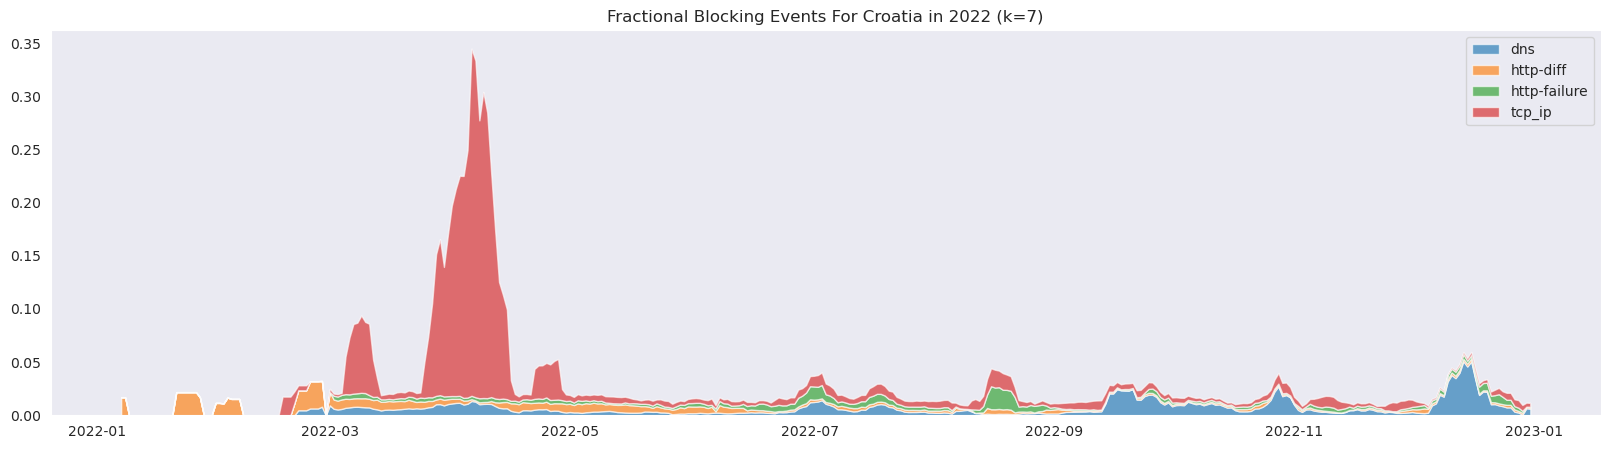

In [15]:
# Select a country and year
country = 'hr'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Croatia in {year} (k={k})')
plt.show()

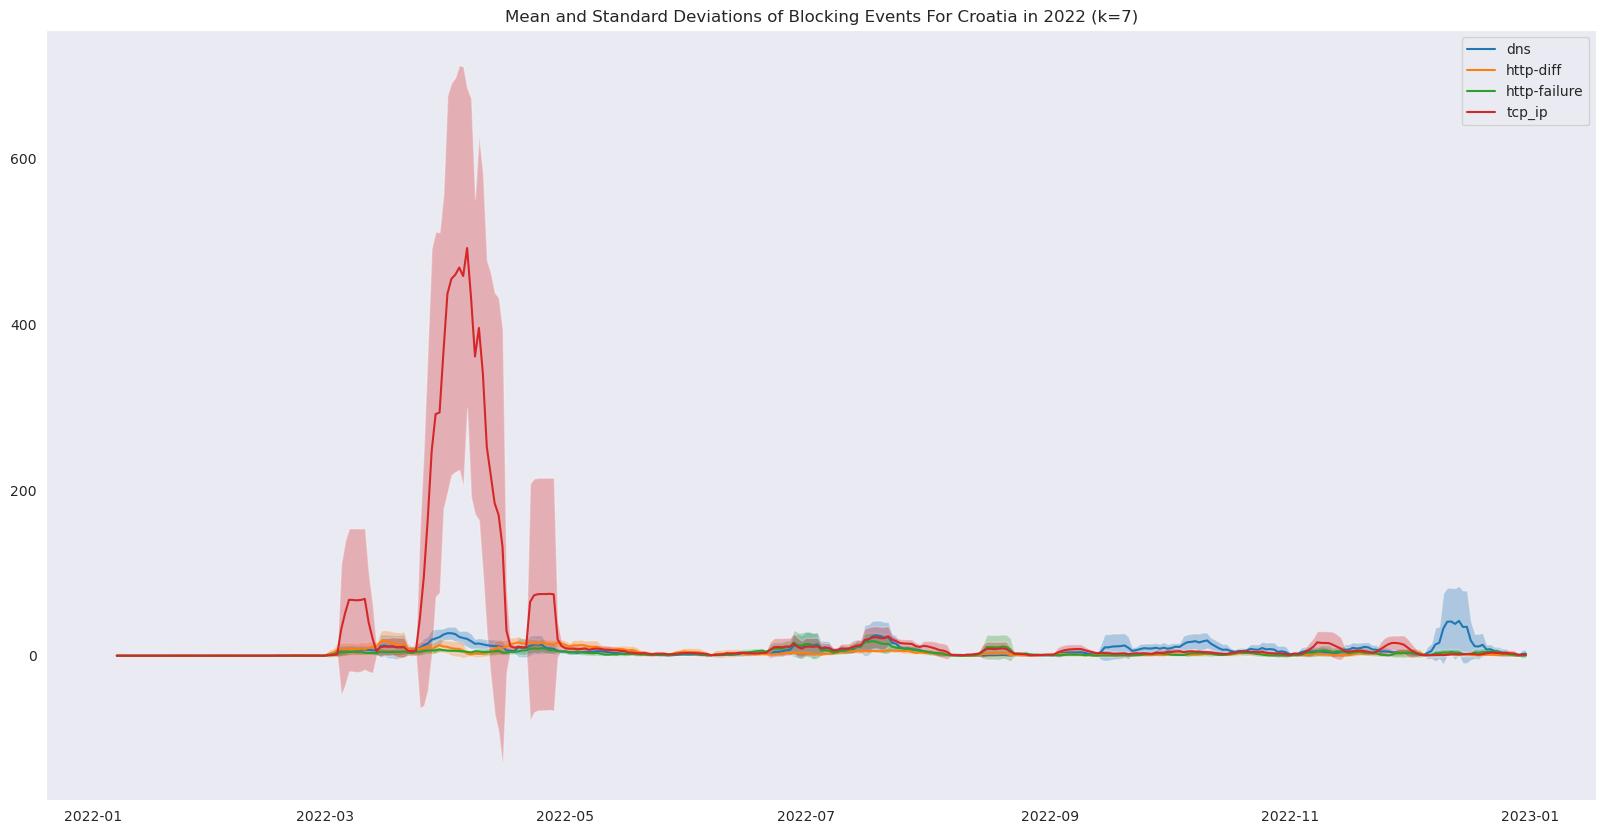

In [16]:
# Get means and standard deviations
m = pd.DataFrame(means[country][year])
m = m.reindex(sorted(m.columns), axis=1)
m = m.drop('False', axis=1)
s = pd.DataFrame(stds[country][year])
s = s.reindex(sorted(s.columns), axis=1)
s = s.drop('False', axis=1)

# Plot mean and standard deviations
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(m, label=m.columns)
for t in m.columns:
    plt.fill_between(m.index, m[t]-s[t], m[t]+s[t], alpha=0.3)
plt.legend()
plt.grid()
plt.title(f'Mean and Standard Deviations of Blocking Events For Croatia in {year} (k={k})')
plt.show()

Looking at these three plots visually, there is clearly something strange going on with Croatia during 2022 which warrants further investigation.

----

## (2) Questions

*You must clearly state the questions you’re attempting to answer.
Some questions could be a bit vague or broad, such as determining the basic
properties of the different attributes, but others should be more specific, such
as determining if a particular relationship exists.*

In our initial proposal, we started with this set of questions:

* What events tend to coincide with increased rates of censorship?
    * If researchers have a better view on what world events tend to correlate with temporal censorship, they can more effectively look for it.
    * We will first attempt to identify censorship events worldwide using the answers to the above question, then we will cross reference them against news stories in the censored region to create new data for us to analyze.

* What methods are countries using to implement censorship today?
    * There are several different methods to implement censorship. What methods are countries using today? How can we discover these trends in the data?
    * We will use different statistical models to try to find correlations between countries/Autonomous Systems (AS’s), and different censorship events.

* How can we effectively identify temporal censorship events?
    * While some censorship is persistent, other censorship is temporary, such as censorship around election times, or times of political unrest. How can we more effectively identify these events?
    * We will investigate this by querying the OONI database across time ranges and countries to find anomalies.
    * We will also try building models to detect these events.


These questions proved to be beyond our paygrade in many ways. We bit off a lot more than we could chew. Most of this came down to the dataset. As discussed in the previous section, the database turned out to be several terabytes in size. We had to pivot, and as stated above, we began studying 3 specific countries during one year (2022), along with an extra two years of Croatian data. All of these countries were smaller than 7.5 GB per year, and thus were manageable. This changed our questions drastically. Our initial questions were impossible to answer, as shown below:


* What events tend to coincide with increased rates of censorship?
    * We now only had 5 years of data. In those 5 years of data, we only found 1 year with significant events. We cannot prove any correlation using 1 year of significance, so we had to abandon this question.

* What methods are countries using to implement censorship today?
    * We will still discuss this, but in a much narrower sense. We can't get a worldwide view of censorship with only 3 countries, but we will aim to categorize and discuss the methods of censorship used in Croatia 2022, the interesting dataset.

* How can we effectively identify temporal censorship events?
    * It became fairly easy to recognize true censorship events by sight. The only major censorship event in our dataset is in Croatia during spring 2022. So we will continue to discuss this, but it is no longer a main focus of the project.

Due to our dataset changes, our questions had to change. Eventually, we decided on a new set of questions to answer for our project:

1. What years of data have anomalies worth spending time on?

2. What date ranges are truly anomalous within our dataset?

3. What is happening inside of our anomalous date ranges?

4. What is being blocked in these date ranges, that is not outside of the ranges?

5. Are these differences statistically significant?

6. How do the different countries compare to each other in terms of blocking events?


----

## (3) Analysis

(INTRO TO ANALYSIS SECTION)

### (3.1) Basic Anomaly Detection

First we try to find potential anomalies automatically using the $95\%$ quantile as a threshold for the mean blocking events.  This produces the following plot of potentially interesting regions of time to investigate further.

In [17]:
# Get the data of interest
country = 'hr'
year = '2022'
w = web_data[country][year]
f = fracs[country][year].drop('False', axis=1)

# Get means and standard deviations
m = pd.DataFrame(means[country][year])
m = m.reindex(sorted(m.columns), axis=1)
m = m.drop('False', axis=1)
s = pd.DataFrame(stds[country][year])
s = s.reindex(sorted(s.columns), axis=1)
s = s.drop('False', axis=1)

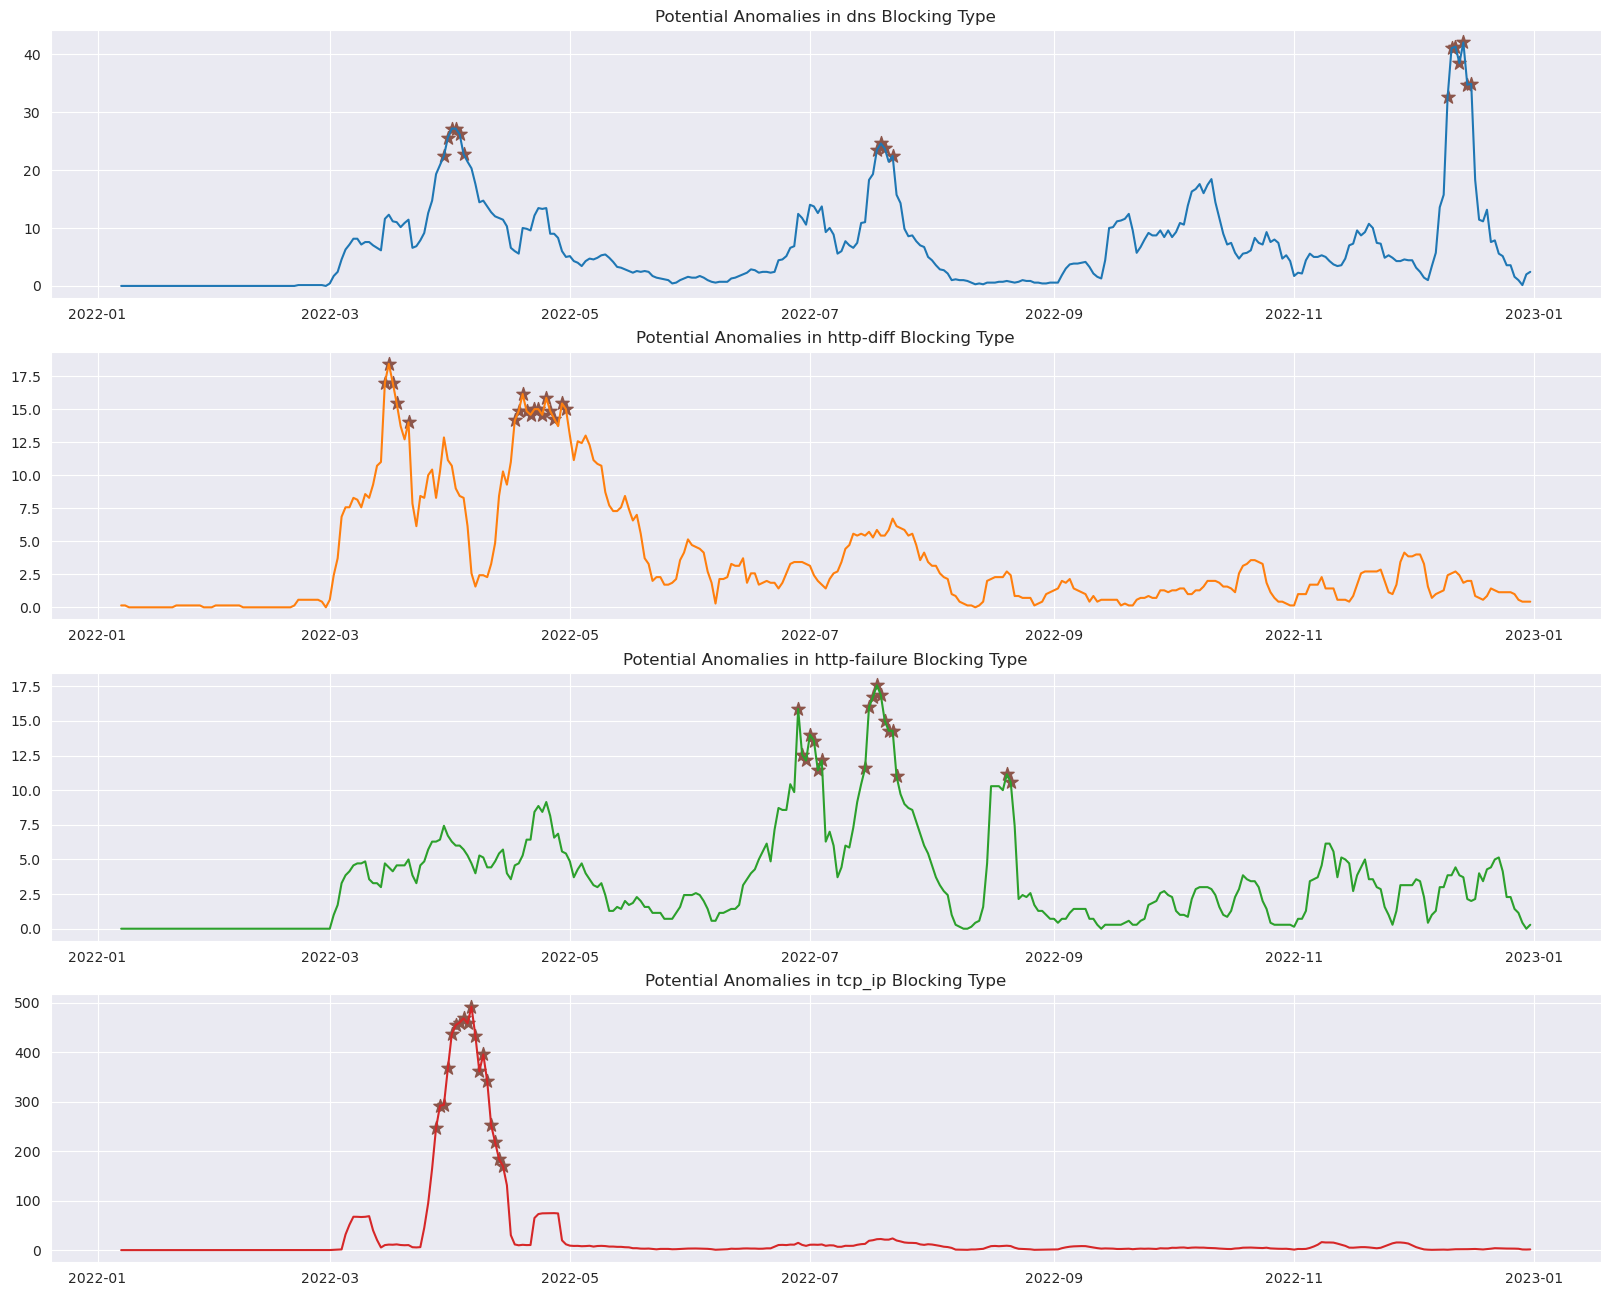

In [18]:
# Perform IQR checks on the mean
iqr = m.quantile([0.05, 0.95])
lb = iqr.iloc[0]
ub = iqr.iloc[1]

# Check for anomalies outside of ranges
au = (m > ub)
al = (m < lb)

# Plot anomalies
plt.figure(figsize=(20, 4*len(m.columns)))
for i, c in enumerate(m.columns):
    # Get color values
    #color = au[c].apply(lambda x: palette[len(m.columns)+1] if x is True else palette[i])
    anom = m[au]

    # Plot
    plt.subplot(len(m.columns), 1, i+1)
    plt.plot(m[c], label=c, color=palette[i])
    plt.scatter(anom.index, anom[c], s=100, color=palette[len(m.columns)+1], marker='*')
    plt.title(f'Potential Anomalies in {c} Blocking Type')
plt.show()

From these plots, we chose 3 date ranges of interest:

* (a) March 1st 2022 to April 30th 2022
* (b) June 15th 2022 to September 1st 2022
* (c) December 5th 2022 to December 31st 2022

### (3.2) Statistical Tests

Next we'd like to characterize the dataset and understand more what is happening inside of these regions of interest versus outside of the regions.  To do this we have to first check some basic statistical tests.

### (3.2.1) Z-Tests

In [19]:
# Define ranges
start_dateA = '2022-03-01'
end_dateA = '2022-04-30'
start_dateB = '2022-06-15'
end_dateB = '2022-09-01'
start_dateC = '2022-12-05'
end_dateC = '2022-12-31'

# Get indices
w_inner_idxA = (w.index >= start_dateA) & (w.index <= end_dateA)
m_inner_idxA = (m.index >= start_dateA) & (m.index <= end_dateA)
w_outer_idxA = ~w_inner_idxA
m_outer_idxA = ~m_inner_idxA

w_inner_idxB = (w.index >= start_dateB) & (w.index <= end_dateB)
m_inner_idxB = (m.index >= start_dateB) & (m.index <= end_dateB)
w_outer_idxB = ~w_inner_idxB
m_outer_idxB = ~m_inner_idxB

w_inner_idxC = (w.index >= start_dateC) & (w.index <= end_dateC)
m_inner_idxC = (m.index >= start_dateC) & (m.index <= end_dateC)
w_outer_idxC = ~w_inner_idxC
m_outer_idxC = ~m_inner_idxC

# Split data into ranges
w_innerA = w[w_inner_idxA]
m_innerA = m[m_inner_idxA]
w_outerA = w[w_outer_idxA]
m_outerA = m[m_outer_idxA]

w_innerB = w[w_inner_idxB]
m_innerB = m[m_inner_idxB]
w_outerB = w[w_outer_idxB]
m_outerB = m[m_outer_idxB]

w_innerC = w[w_inner_idxC]
m_innerC = m[m_inner_idxC]
w_outerC = w[w_outer_idxC]
m_outerC = m[m_outer_idxC]

First we perform a two sample Z-Test in order to determine if the mean values of each type of blocking method are different within each date range versus outside of each date range.

We run the Z-Test for date range **(a)** versus outside of the date range:

In [28]:
# Get the 2 Sample Z-Test
pd.DataFrame(ztest(m_innerA, m_outerA, value=0), index=['Z Statistic', 'p-value'], columns=m_innerA.columns)

,dns,http-diff,http-failure,tcp_ip
Z Statistic,6.041636e+00,1.880703e+01,4.169273,1.378721e+01
p-value,1.525592e-09,6.613715e-79,0.000031,3.043069e-43


Given that all of the blocking event types pass the p-value threshold of $0.05$, we can reject the null hypothesis that the distributions of these blocking events have the same means.  This likely means that the **(a)** date range distribution of blocking events are all distinct from other times throughout the year.

Next we run the Z-Test for the date range **(b)** versus outside of the date range:

In [21]:
# Get the 2 Sample Z-Test
pd.DataFrame(ztest(m_innerB, m_outerB, value=0), index=['Z Statistic', 'p-value'], columns=m_innerB.columns)

,dns,http-diff,http-failure,tcp_ip
Z Statistic,-0.453515,-1.926296,1.222851e+01,-2.230284
p-value,0.650178,0.054067,2.189270e-34,0.025729


Given that only the `http-failure` and `tcp_ip` blocking events pass the p-value threshold of $0.05$, we can only reject the null hypothesis that the distributions have the same means inside versus outside of the date range.

Finally we run the Z-Test for the date range **(c)** versus outside of the date range:

In [22]:
# Get the 2 Sample Z-Test
pd.DataFrame(ztest(m_innerC, m_outerC, value=0), index=['Z Statistic', 'p-value'], columns=m_innerC.columns)

,dns,http-diff,http-failure,tcp_ip
Z Statistic,6.296285e+00,-2.966596,-1.077220,-1.640400
p-value,3.048631e-10,0.003011,0.281382,0.100922


We can only reject the null hypothesis for the `dns` blocking event type in this case, which matches our assumptions from the detected anomalies from above.

### (3.2.2) Time Series Characterization

Next we try to validate some properties about the time series itself, namely:

* Stationarity - Whether the data is not a function of time
* Autocorrelation - Whether the time series dataset has any lags which are related to the current time step
* Partial Autocorrelation - Whether the time series is related to its past values while controlling for intervening values which can indicate the influence of lagged observations on the current observation excluding other lags

To determine stationarity, we use the Augmented Dickey-Fuller test, which is a statistical test that tries to evaluate whether the null hypothesis that a particular time series dataset is non-stationary, meaning that the data is a function of time. If the test's p-value is below a significance threshold, we can reject this and assume our data is stationary, which makes modeling the relationship a bit less complicated.

In [29]:
# Compute rolling totals, means, and standard deviations
k=1
totals1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
means1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
stds1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quarts1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quants1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
for country in blocking_events:
    for year in blocking_events[country]:
        for event_type in blocking_events[country][year]:
            # Calculate date range
            date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

            # Fill all empty events with zeroes
            d = blocking_events[country][year][event_type]
            tmp = d.groupby(d.index).size()
            totals1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()
            means1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().dropna()
            stds1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).std().dropna()
            quarts1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.25, 0.75]).dropna()
            quants1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.01, 0.1, 0.9, 0.99]).dropna()

In [50]:
# Compute ADF
t = totals1['hr']['2022']
tdf = pd.DataFrame(t).drop('False', axis=1)
adf_tests = { typ : [adfuller(t[typ])[0], adfuller(t[typ])[1]] for typ in blocking_events['hr']['2022'] if typ not in ['False']}
pd.DataFrame(adf_tests, index=['ADF Statistic', 'p-value'])

,dns,http-diff,http-failure,tcp_ip
ADF Statistic,-5.462238,-2.93027,-4.336395,-2.706767
p-value,0.000003,0.04194,0.000384,0.072875


Since the p-values of all of the blocking events except for `tcp_ip` is below the threshold $0.05$, then we can safely reject the null hypothesis that the time series data is non-stationary in those specific cases.  This means that the data in the other blocking event types is likely to be stationary in the 0th order.  For `tcp_ip` more analysis is necessary to determine its characteristics.

In order to determine what point that the `tcp_ip` blocking events become stationary, we use the 1st order and 2nd order differential tests and the autorrelation of those.

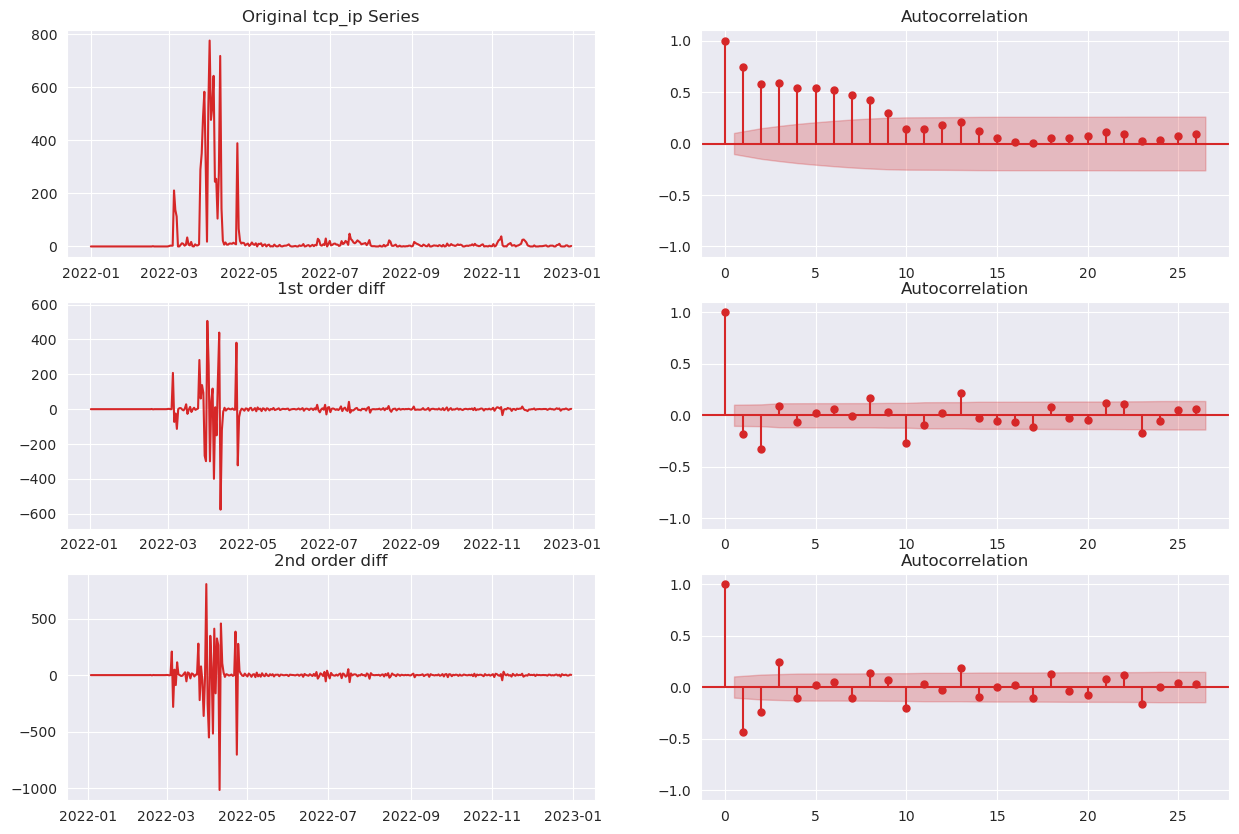

In [72]:
# Set plot options
plt.rcParams['figure.figsize'] = [15, 10]
color = palette[len(tdf.columns)-1]

# Calculate differentials
diff_0 = tdf['tcp_ip']
diff_1 = diff_0.diff().dropna()
diff_2 = diff_1.diff().dropna()

# Plot all differentials and their autocorrelation
fig, axes = plt.subplots(3,2, sharex=False)
axes[0, 0].plot(diff_0, color=color)
axes[0, 0].set_title('Original tcp_ip Series')
plot_acf(diff_0, ax=axes[0, 1])
axes[0, 1].set_ylim(-1.1, 1.1)

# 1st order differencing
axes[1, 0].plot(diff_1, color=color)
axes[1, 0].set_title('1st order diff')
axes[1, 0].set_ymargin(0.1)
plot_acf(diff_1, ax=axes[1, 1])
axes[1, 1].set_ylim(-1.1, 1.1)

# 2nd order differencing
axes[2, 0].plot(diff_2, color=color)
axes[2, 0].set_title('2nd order diff')
plot_acf(diff_2, ax=axes[2, 1])
axes[2,1].set_ylim(-1.1, 1.1)

for i in range(0,3):
    for line in axes[i,1].get_lines():
        line.set_color(color)
    for marker in axes[i,1].collections:
        marker.set_color(color)

# Show the plot
plt.show()

From these graphs we can conclude that the data becomes stationary likely at its 1st order differential given that the peaks in the autocorrelation factor plot settle close to the threshold very quickly.

Next we run autocorrelation and  partial autocorrelation factor analysis on the rest of the raw totals to see what types of intra-series relationships there are.

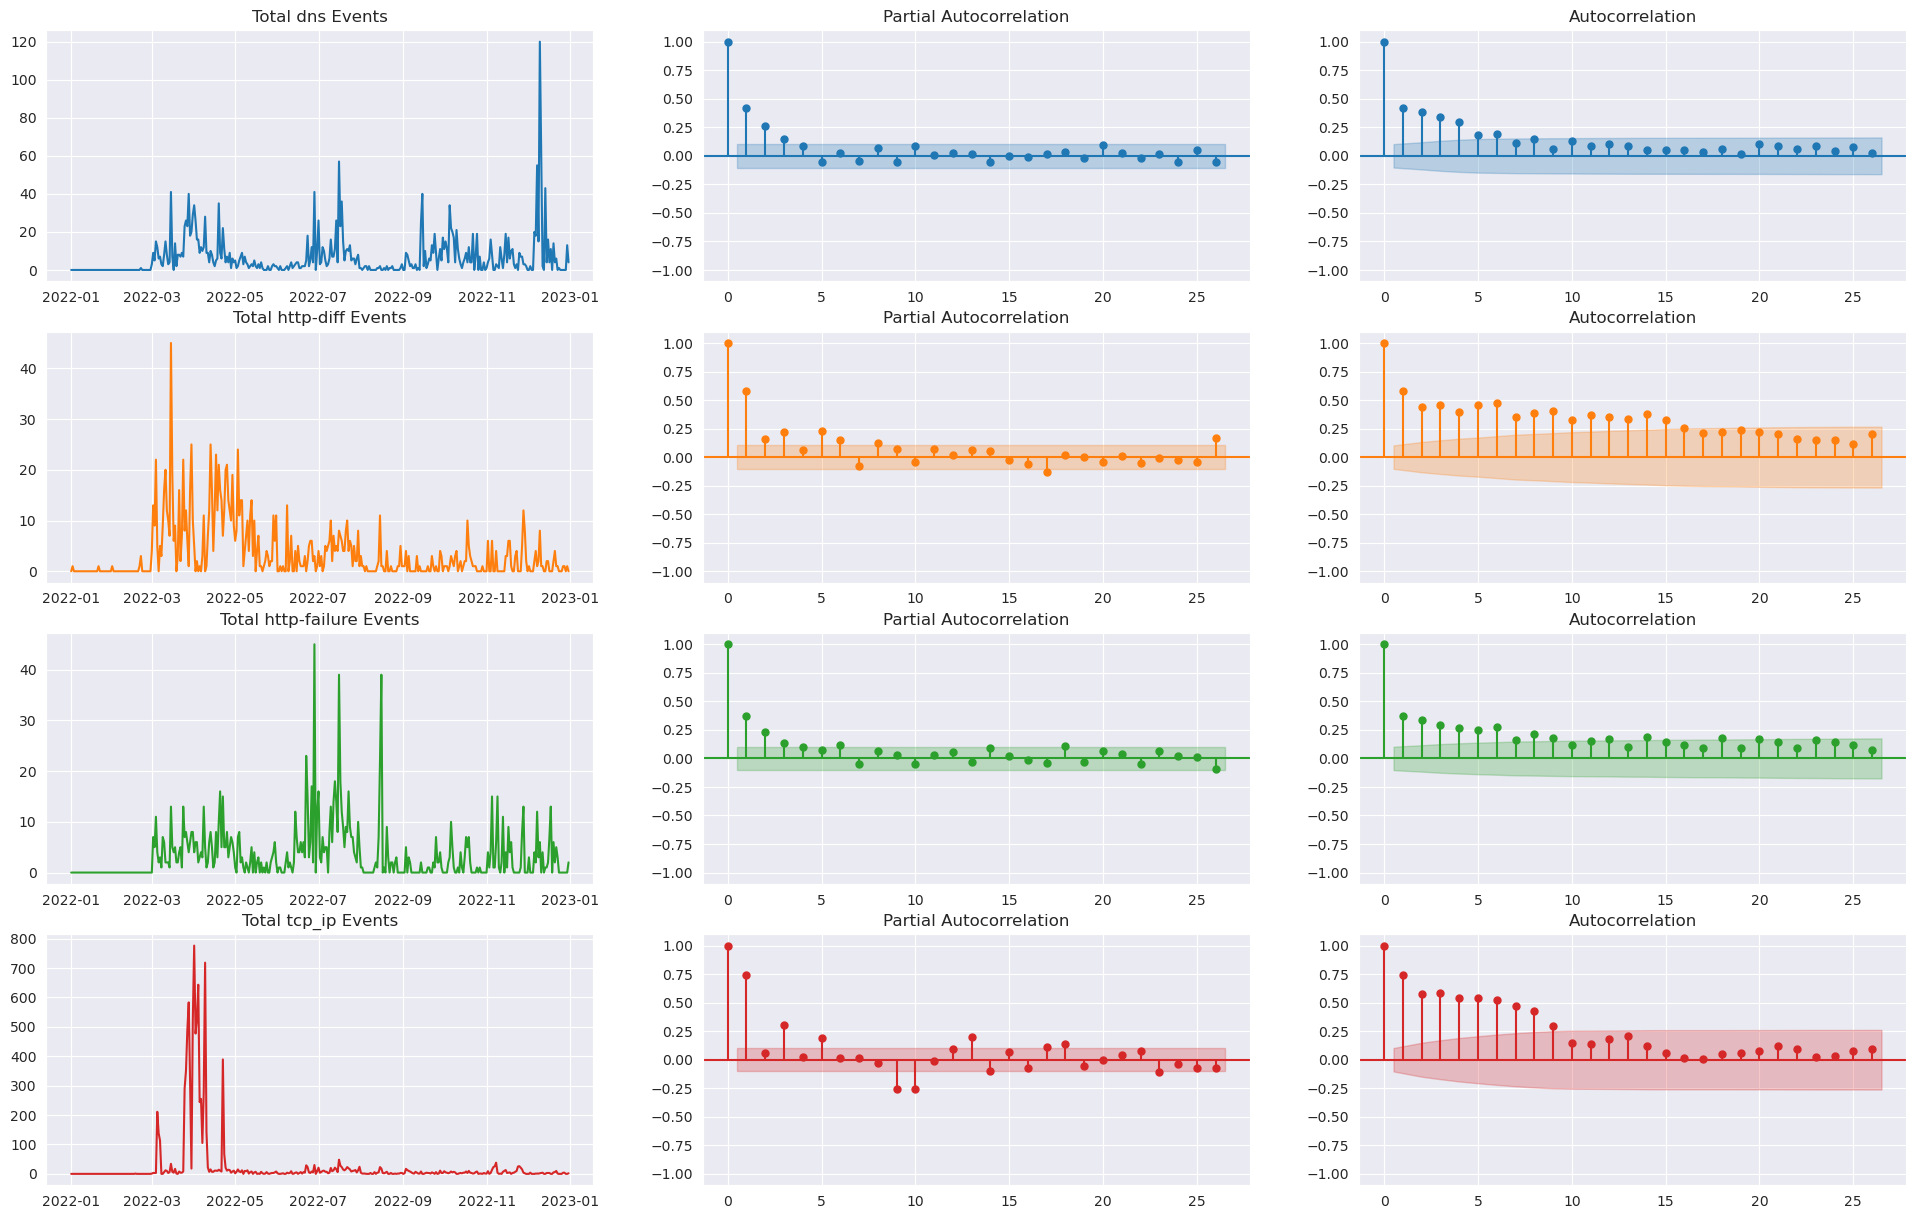

In [67]:
# Set plot options
plt.rcParams['figure.figsize'] = [len(tdf.columns)*6, 15]

# Plot
fig, axes = plt.subplots(len(tdf.columns), 3, sharex=False)
for i, t in enumerate(tdf.columns):
    axes[i,0].plot(tdf[t], color=palette[i])
    axes[i,0].set_title(f'Total {t} Events')
    plot_pacf(tdf[t].dropna(), ax=axes[i,1], color=palette[i])
    axes[i,1].set(ylim=(-1.1,1.1))
    plot_acf(tdf[t].dropna(), ax=axes[i,2], color=palette[i])
    axes[i,2].set(ylim=(-1.1, 1.1))
    for j in range(1,3):
        for line in axes[i,j].get_lines():
            line.set_color(palette[i])
        for marker in axes[i,j].collections:
            marker.set_color(palette[i])
plt.show()

From these plots we can see that most of the models have 1st, 2nd, and 3rd order partial autocorrelation factors above the threshold of acceptance, likely meaning that there is some intra-day relationships from past days up to those size windows.  None of the blocking events seem to indicate that they have any seasonality due to the fact that there is steady dropoff without any regular peaks.  It is also interesting to see that `tcp-ip` has peaks at orders 1, 3, 5, 9, and 10 which are potential parameters to try during modeling.

In terms of the Z-Test that was done earlier, there are limits on what conclusions can be drawn due to the fact that all of the blocking events are not exactly independently distributed, however due to the fact that the autocorrelation drops of farily steadily in all cases, it can be concluded that statistically it is likely for the different date ranges to actually have the differences from the means that we observed. 

As for autocorrelation, most of the different events have steady decline in autocorrelation, meaning that the series may have fairly short term memory of its events.  There do not seem to be any strong trends or seasonal patterns which seems consistent with just visual inspection of the data as well.

### (3.3) Time Series Modeling

Now that we have characterized the data iself, we would like to build models of the data using the Auto Regressive Integrated Moving Average method (ARIMA).  This method is split into 3 different parts:

* `p` - The autoregressive (AR) term refers to the order in which the model depends on a specific lag factor
* `d` - The integration (I) term refers to which order that the data is stationary in
* `q` - The moving average (MA) term refers to where the output depends only on lagged errors

For every blocking event except `tcp_ip` we are assuming the data to be stationary which means its `d` term is nonzero (and from our previous explorations we've determined it is likely $d=1$).

We test a few different models for each method and compare their AIC and BIC values.

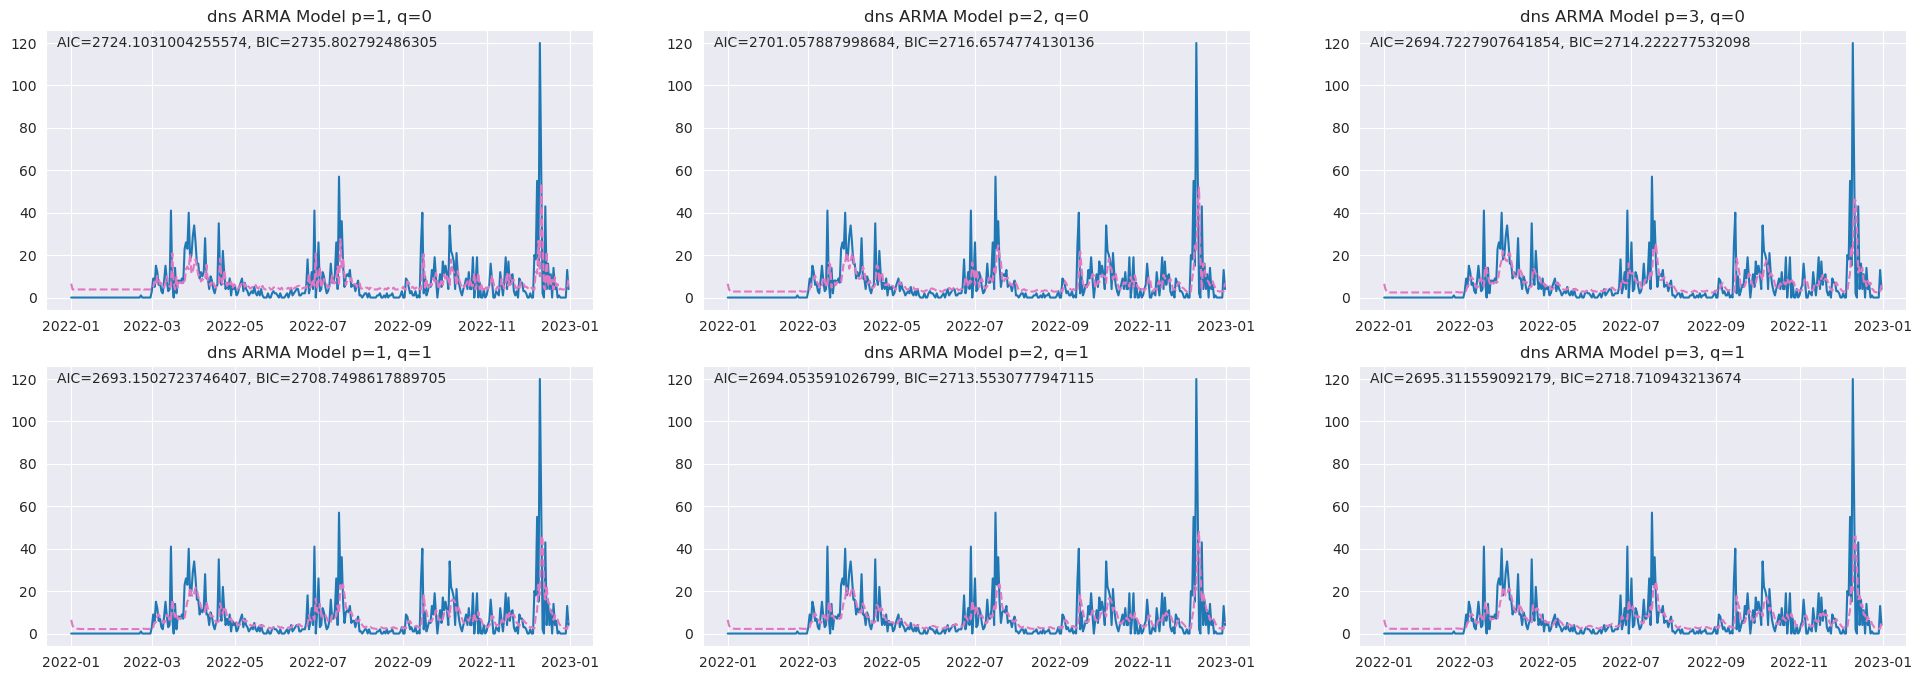

In [96]:
# Try out different ARMA terms
ar_orders = [1,2,3]
ma_orders = [0,1]

# Type and color
i = 0
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 0, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From this exploration of model parameters, we can see that the model with the lowest AIC as well as BIC is the model with $p=1$, $q=1$.  This likely means that first order auto regression and first order moving average are decent predictors of future behavior in the `dns` data (therefore a period of 1 day likely predicts the next day).

In [98]:
fitted_models[1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    dns   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1342.575
Date:                Sun, 16 Mar 2025   AIC                           2693.150
Time:                        20:34:20   BIC                           2708.750
Sample:                    01-01-2022   HQIC                          2699.350
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4474      2.522      2.556      0.011       1.503      11.391
ar.L1          0.8584      0.031     27.325      0.000       0.797       0.920
ma.L1         -0.5676      0.048    -11.766      0.000      -0.662      -0.473
sigma2        91.6184      2.054     44.615      0.000      87.594      95.643
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):             23501.89
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               4.08   Skew:                             4.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For the `http-diff` blocking events, we see that there are peaks in the partial autocorrelation function plots at 1,3,5, and 6, so we test these values for the AR orders.

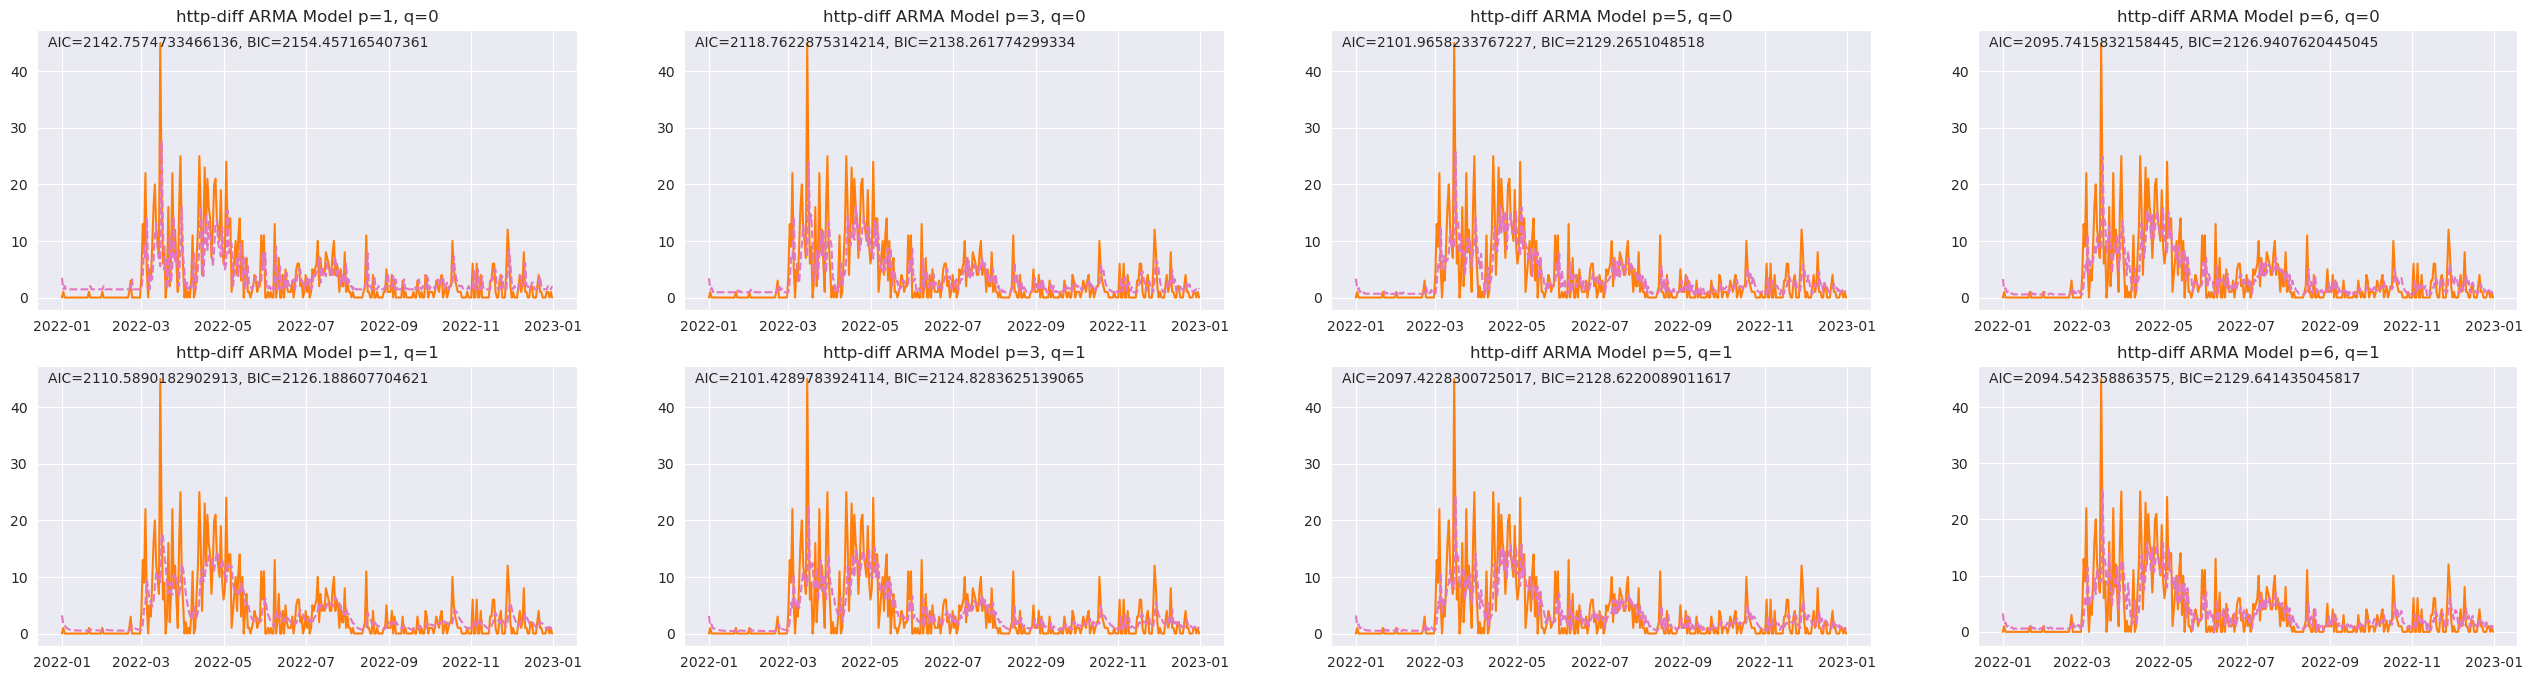

In [126]:
# Try out different ARMA terms
ar_orders = [1,3,5,6]
ma_orders = [0,1]

# Type and color
i = 1
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 0, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From these plots we see that the model with the lowest AIC is where $p=6$ and $q=1$, however the model with the lowest BIC is where $p=3$ and $q=1$.  Depending on whether we want to prioritize accuracy at the expense of using more data points for fitting, we would either choose the 6th or the 3rd order models for this blocking type.  We can conclude however that a moving average term does make a slight difference on model accuracy, and that there are potentially 3rd order to 6th order terms that have a decent impact on model prediction.

In [127]:
fitted_models[6][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              http-diff   No. Observations:                  365
Model:                 ARIMA(6, 0, 1)   Log Likelihood               -1038.271
Date:                Sun, 16 Mar 2025   AIC                           2094.542
Time:                        21:05:22   BIC                           2129.641
Sample:                    01-01-2022   HQIC                          2108.491
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2879      1.981      1.659      0.097      -0.596       7.171
ar.L1         -0.0463      0.176     -0.263      0.793      -0.392       0.299
ar.L2          0.1937      0.086      2.245      0.025       0.025       0.363
ar.L3          0.1567      0.047      3.313      0.001       0.064       0.249
ar.L4          0.0414      0.045      0.929      0.353      -0.046       0.129
ar.L5          0.1431      0.039      3.689      0.000       0.067       0.219
ar.L6          0.2551      0.052      4.928      0.000       0.154       0.357
ma.L1          0.4498      0.188      2.397      0.017       0.082       0.818
sigma2        17.2590      0.605     28.518      0.000      16.073      18.445
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5145.02
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the case of the `http-fail`, there are peaks at periods of 1, 2, and 3 in the partial autocorrelation factor plots, so we test out these in the AR terms.

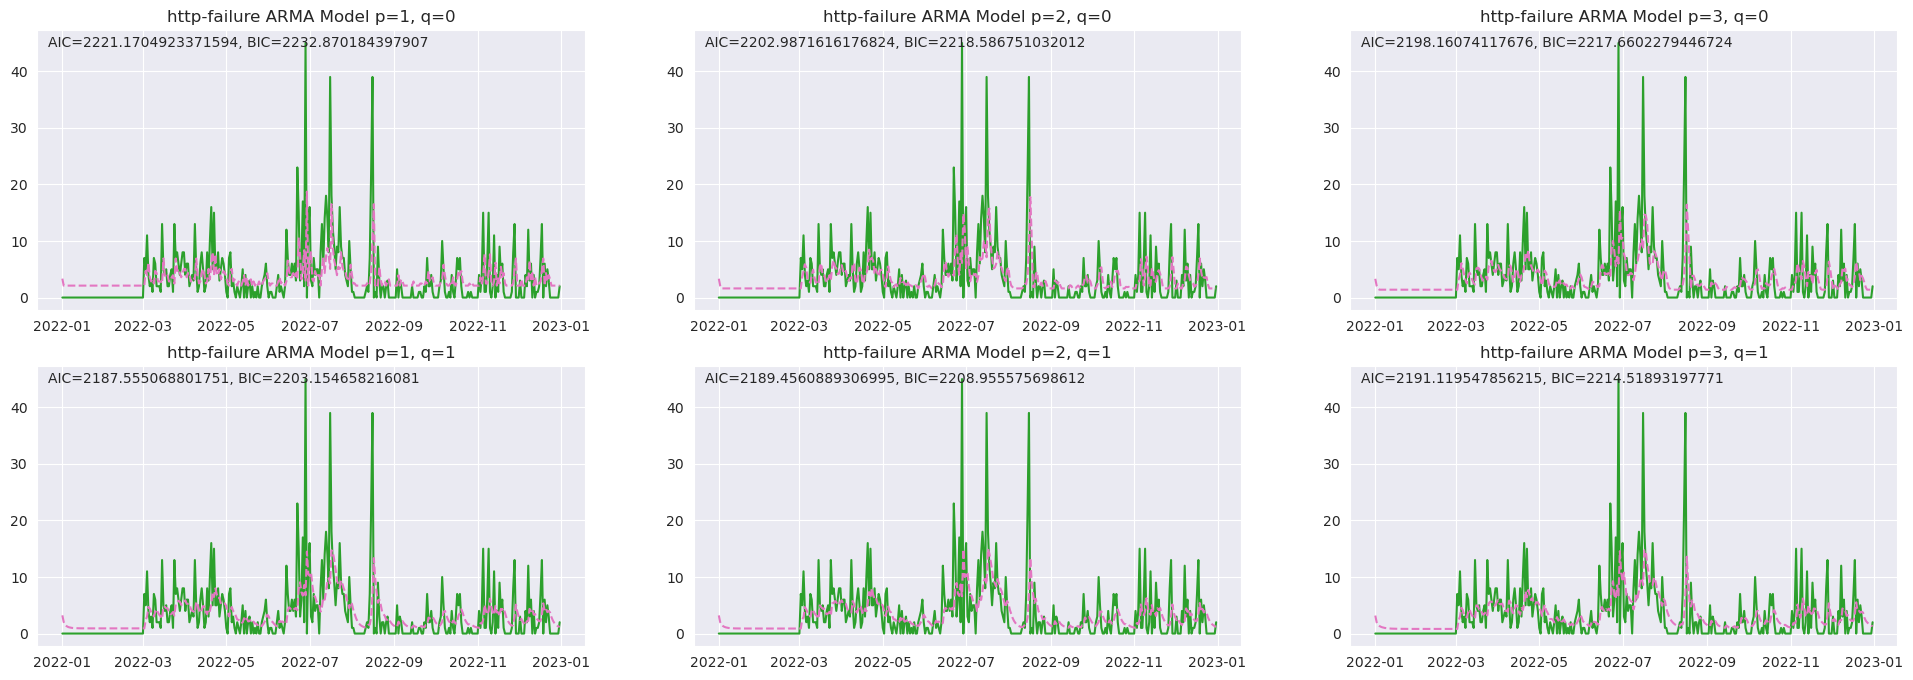

In [128]:
# Try out different ARMA terms
ar_orders = [1,2,3]
ma_orders = [0,1]

# Type and color
i = 2
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 0, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From these plots we can conclude that the $p=1$, and $q=1$ model has both the lowest AIC and BIC, likely drawing the same conclusions as the `dns` blocking model.  It is likely that the data for this test depends only on its nearest neighbor in the time series.

In [129]:
fitted_models[1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           http-failure   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1089.778
Date:                Sun, 16 Mar 2025   AIC                           2187.555
Time:                        21:05:41   BIC                           2203.155
Sample:                    01-01-2022   HQIC                          2193.755
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2185      1.488      2.163      0.031       0.302       6.135
ar.L1          0.9166      0.029     31.530      0.000       0.860       0.974
ma.L1         -0.7067      0.037    -19.358      0.000      -0.778      -0.635
sigma2        22.9265      0.742     30.893      0.000      21.472      24.381
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              7327.69
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             3.47
Prob(H) (two-sided):                  0.03   Kurtosis:                        23.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Finally, for the `tcp_ip` blocking models, we have to use an integration term $d=1$ due to the fact that it is not unlikely that the 0th order data is non-stationary.  Therefore the integration term set to 1 will consider the first order difference to be the stationary set.  There are peaks in the partial autocorrelation plots at 1, 2, 8, and 10 which we test with the AR terms of the model.

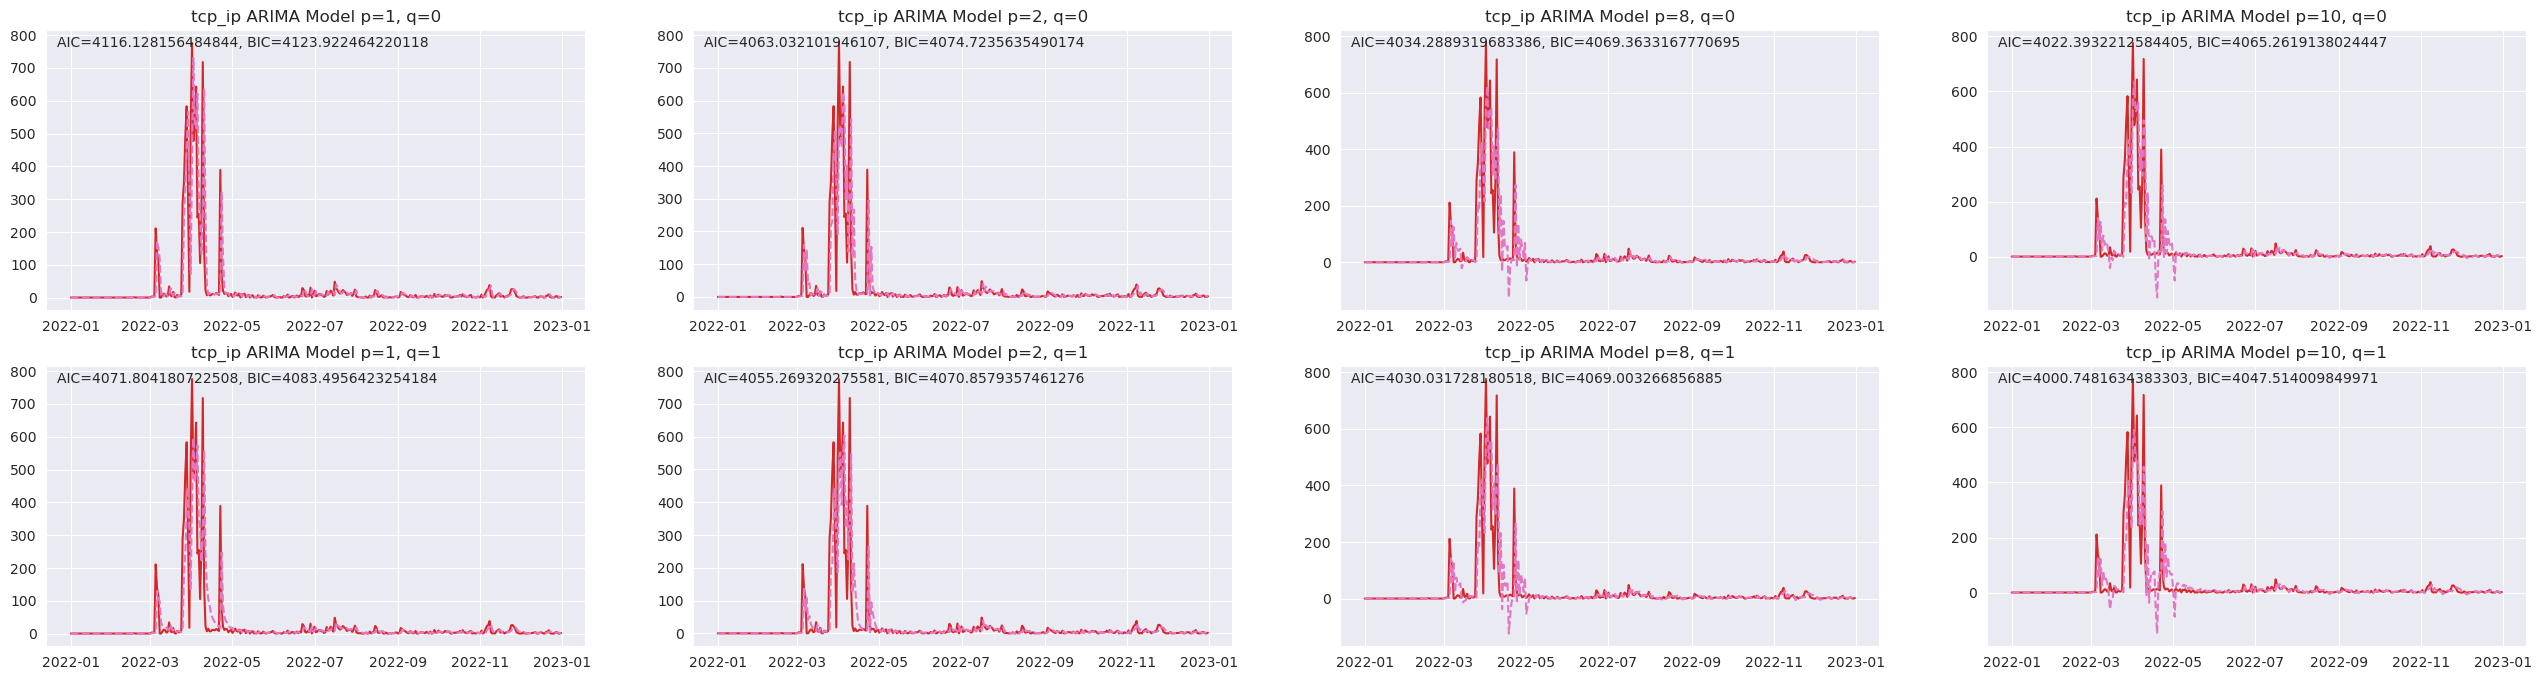

In [132]:
# Try out different ARMA terms
ar_orders = [1,2,8,10]
ma_orders = [0,1]

# Type and color
i = 3
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 1, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARIMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From these plots we can conclude that the best model is where $p=10$ and $q=1$ since this is where both AIC and BIC are the lowest.  This model captures more of the chaotic nature during the anomalous spike event with its higher order terms, but also overshoots those values in order to fit them.

In [133]:
fitted_models[10][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 tcp_ip   No. Observations:                  365
Model:                ARIMA(10, 1, 1)   Log Likelihood               -1988.374
Date:                Sun, 16 Mar 2025   AIC                           4000.748
Time:                        21:11:13   BIC                           4047.514
Sample:                    01-01-2022   HQIC                          4019.335
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5196      0.037     14.025      0.000       0.447       0.592
ar.L2         -0.1701      0.023     -7.425      0.000      -0.215      -0.125
ar.L3          0.2824      0.033      8.519      0.000       0.217       0.347
ar.L4         -0.0470      0.033     -1.427      0.154      -0.112       0.018
ar.L5          0.1842      0.032      5.723      0.000       0.121       0.247
ar.L6          0.0578      0.033      1.728      0.084      -0.008       0.123
ar.L7          0.0662      0.043      1.537      0.124      -0.018       0.151
ar.L8          0.0756      0.035      2.137      0.033       0.006       0.145
ar.L9         -0.0832      0.040     -2.070      0.038      -0.162      -0.004
ar.L10        -0.2875      0.025    -11.326      0.000      -0.337      -0.238
ma.L1         -0.9076      0.027    -33.570      0.000      -0.961      -0.855
sigma2      3232.7776     91.481     35.338      0.000    3053.478    3412.077
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              3823.43
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

----

## (4) Conclusions